In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nba = pd.read_csv("nba_2013.csv")

In [0]:
point_guards = nba[nba['pos']=='PG']

In [18]:
point_guards['ppg'] = point_guards['pts'] / point_guards['g']

# Sanity check, make sure ppg = pts/g
point_guards[['pts', 'g', 'ppg']].head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,pts,g,ppg
24,930,71,13.098592
29,150,20,7.500000
30,660,79,8.354430
38,666,72,9.250000
50,378,55,6.872727


In [0]:
point_guards = point_guards[point_guards['tov'] != 0]

point_guards['atr'] = point_guards['ast'] / point_guards['tov']

In [0]:
num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]

In [0]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)

In [22]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print(calculate_distance(q, p))

2.23606797749979


In [0]:
def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)
        
        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id 
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

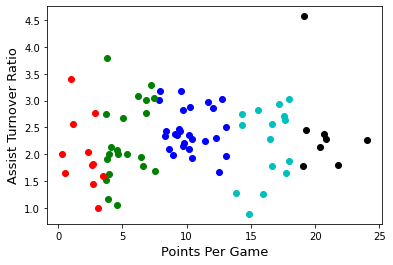

In [29]:
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)

visualize_clusters(point_guards, 5)

In [0]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    # 0..1...2...3...4
    for cluster_id in range(0, num_clusters):
        values_in_cluster = df[df['cluster'] == cluster_id]
        # Calculate new centroid using mean of values in the cluster
        new_centroid = [np.average(values_in_cluster['ppg']), np.average(values_in_cluster['atr'])]
        new_centroids_dict[cluster_id] = new_centroid
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)

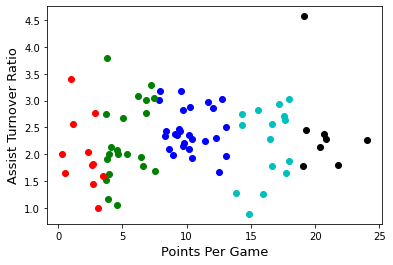

In [31]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

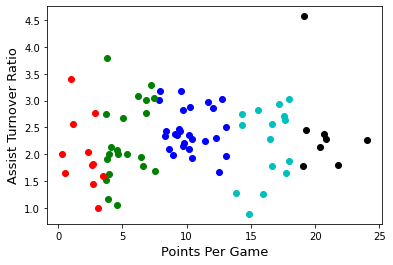

In [36]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

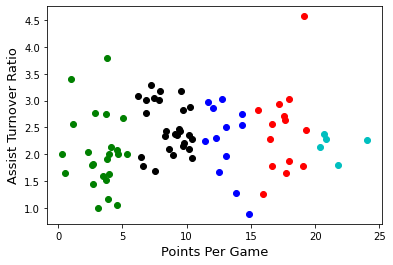

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)